In [1]:
import sys, os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
from utilities import utils
from stats_tools import vis as svis
import numpy as np
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime as dt
import datetime
import string
#%matplotlib inline
#plt.style.use('ggplot')
import importlib
importlib.reload(svis)
print(base_dir)
#plt.style.use(join(base_dir, 'utilities', 'plot_style.txt'))
import importlib
import matplotlib.dates as mdates
from pylab import cm
#mpl.rcParams['pdf.fonttype'] = 42
#mpl.rcParams['ps.fonttype'] = 42

#mpl.rcParams['font.family'] = 'Arial'
"""
params = {'figure.dpi':350,
        'legend.fontsize': 18,#
        'figure.figsize': [6.4, 4.8],
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'axes.facecolor':'white'}
mpl.rcParams.update(params) 
"""
import proplot as pplt

#plt.style.use(join(base_dir, 'utilities', 'plot_style.txt'))
pplt.rc.cycle = 'ggplot'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

c:\Users\kiril\Thesis\CoBra\cobra


## AcquisitionContrast Column can be dropped

In [2]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
# dfc = utils.load_scan_csv(join(table_dir, 'scan_tables','scan_after_sq_pred_dst.csv'))
with open(join(table_dir, 'scan_tables','scan_after_sq_pred_dst_nos_date.pkl'), 'rb') as f:
    dfc = pickle.load(f)

In [36]:
dfc['positive'] = 0
dfc.loc[dfc.days_since_test>=-4, 'positive'] = 1

## Drop missing dates from 2020

In [37]:
dfcc = dfc[(dfc['2019']==1)|(~dfc.InstanceCreationDate.isna())]

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


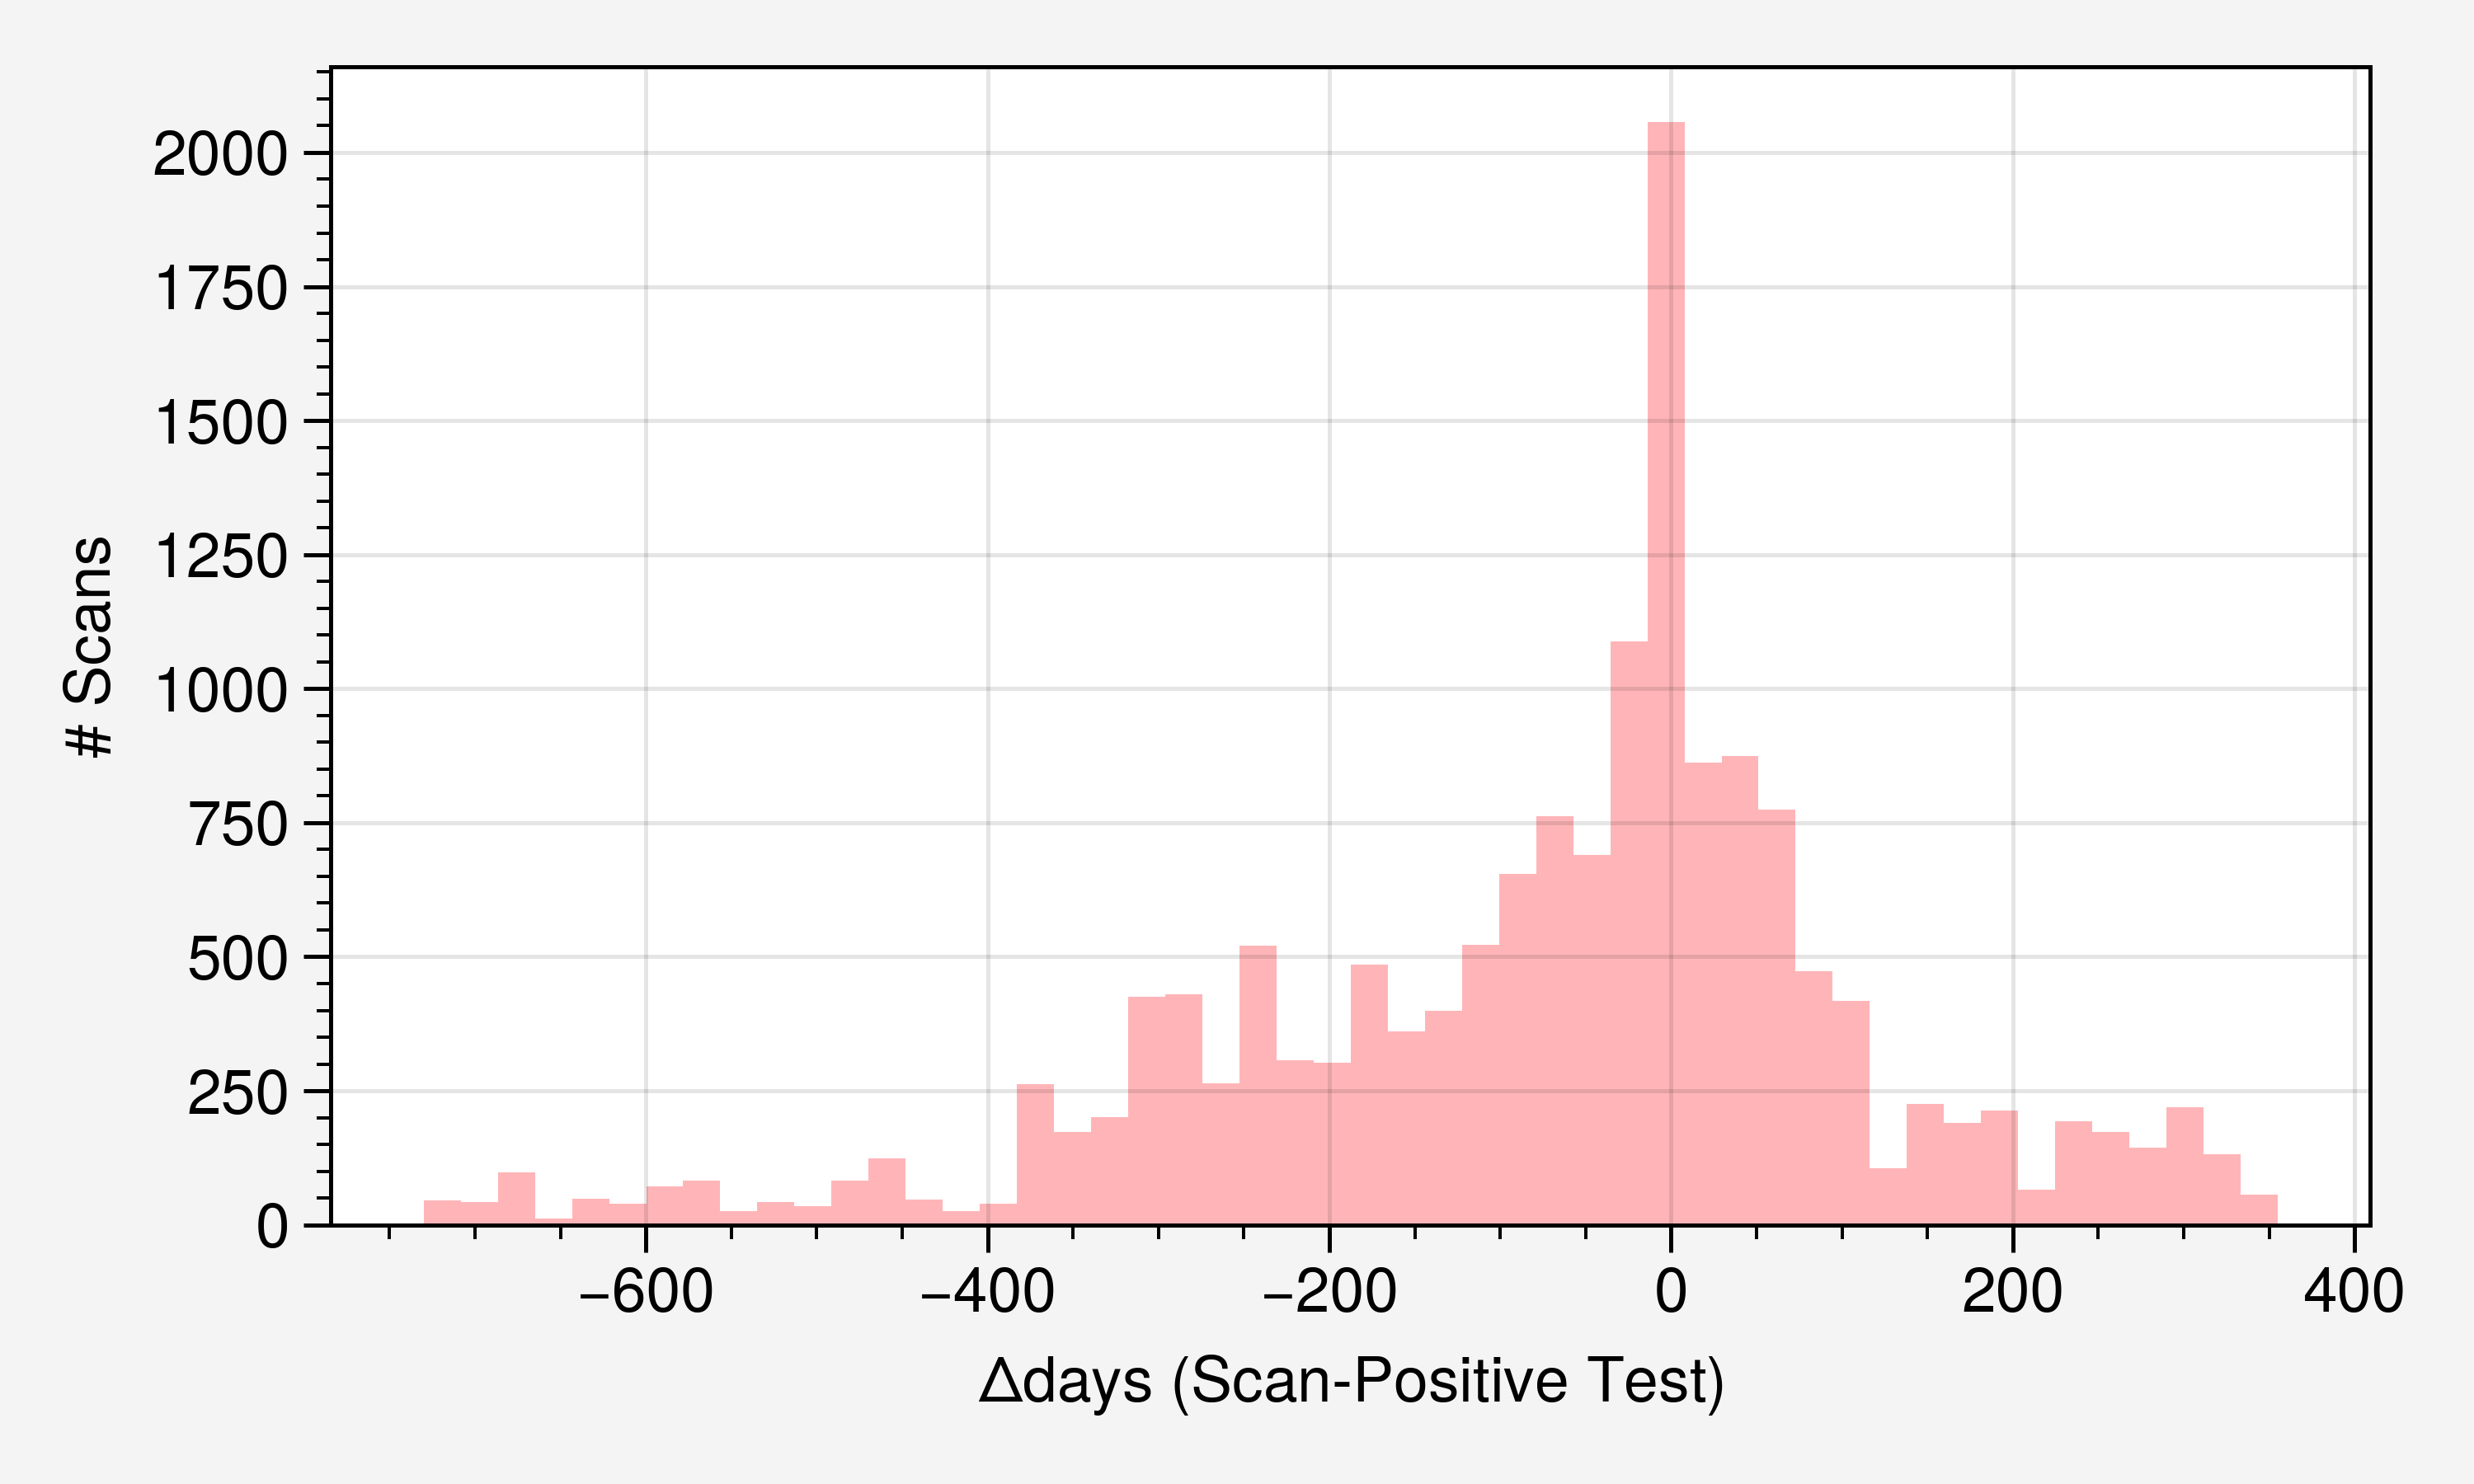

In [91]:
#mpl.rcParams['figure.dpi'] = 100
#fig = pplt.figure(figsize=(4,3))
#ax = fig.subplot(xlabel='x axis', ylabel='y axis')
fig, ax = plt.subplots(figsize=(5,3))
dfc.days_since_test.hist(ax=ax, bins=50, color=colors[6])
ax.set_xlabel(r'$\Delta$'+'days (Scan-Positive Test)')
ax.set_ylabel('# Scans')
fig.tight_layout()
#fig.savefig(join(fig_dir, 'basic_stats', 'days_since_test.png'), dpi=1000, 
 #   bbox_to_inches='tight')

## Number of positive and negative patients by modality

(0.0, 25600.0)

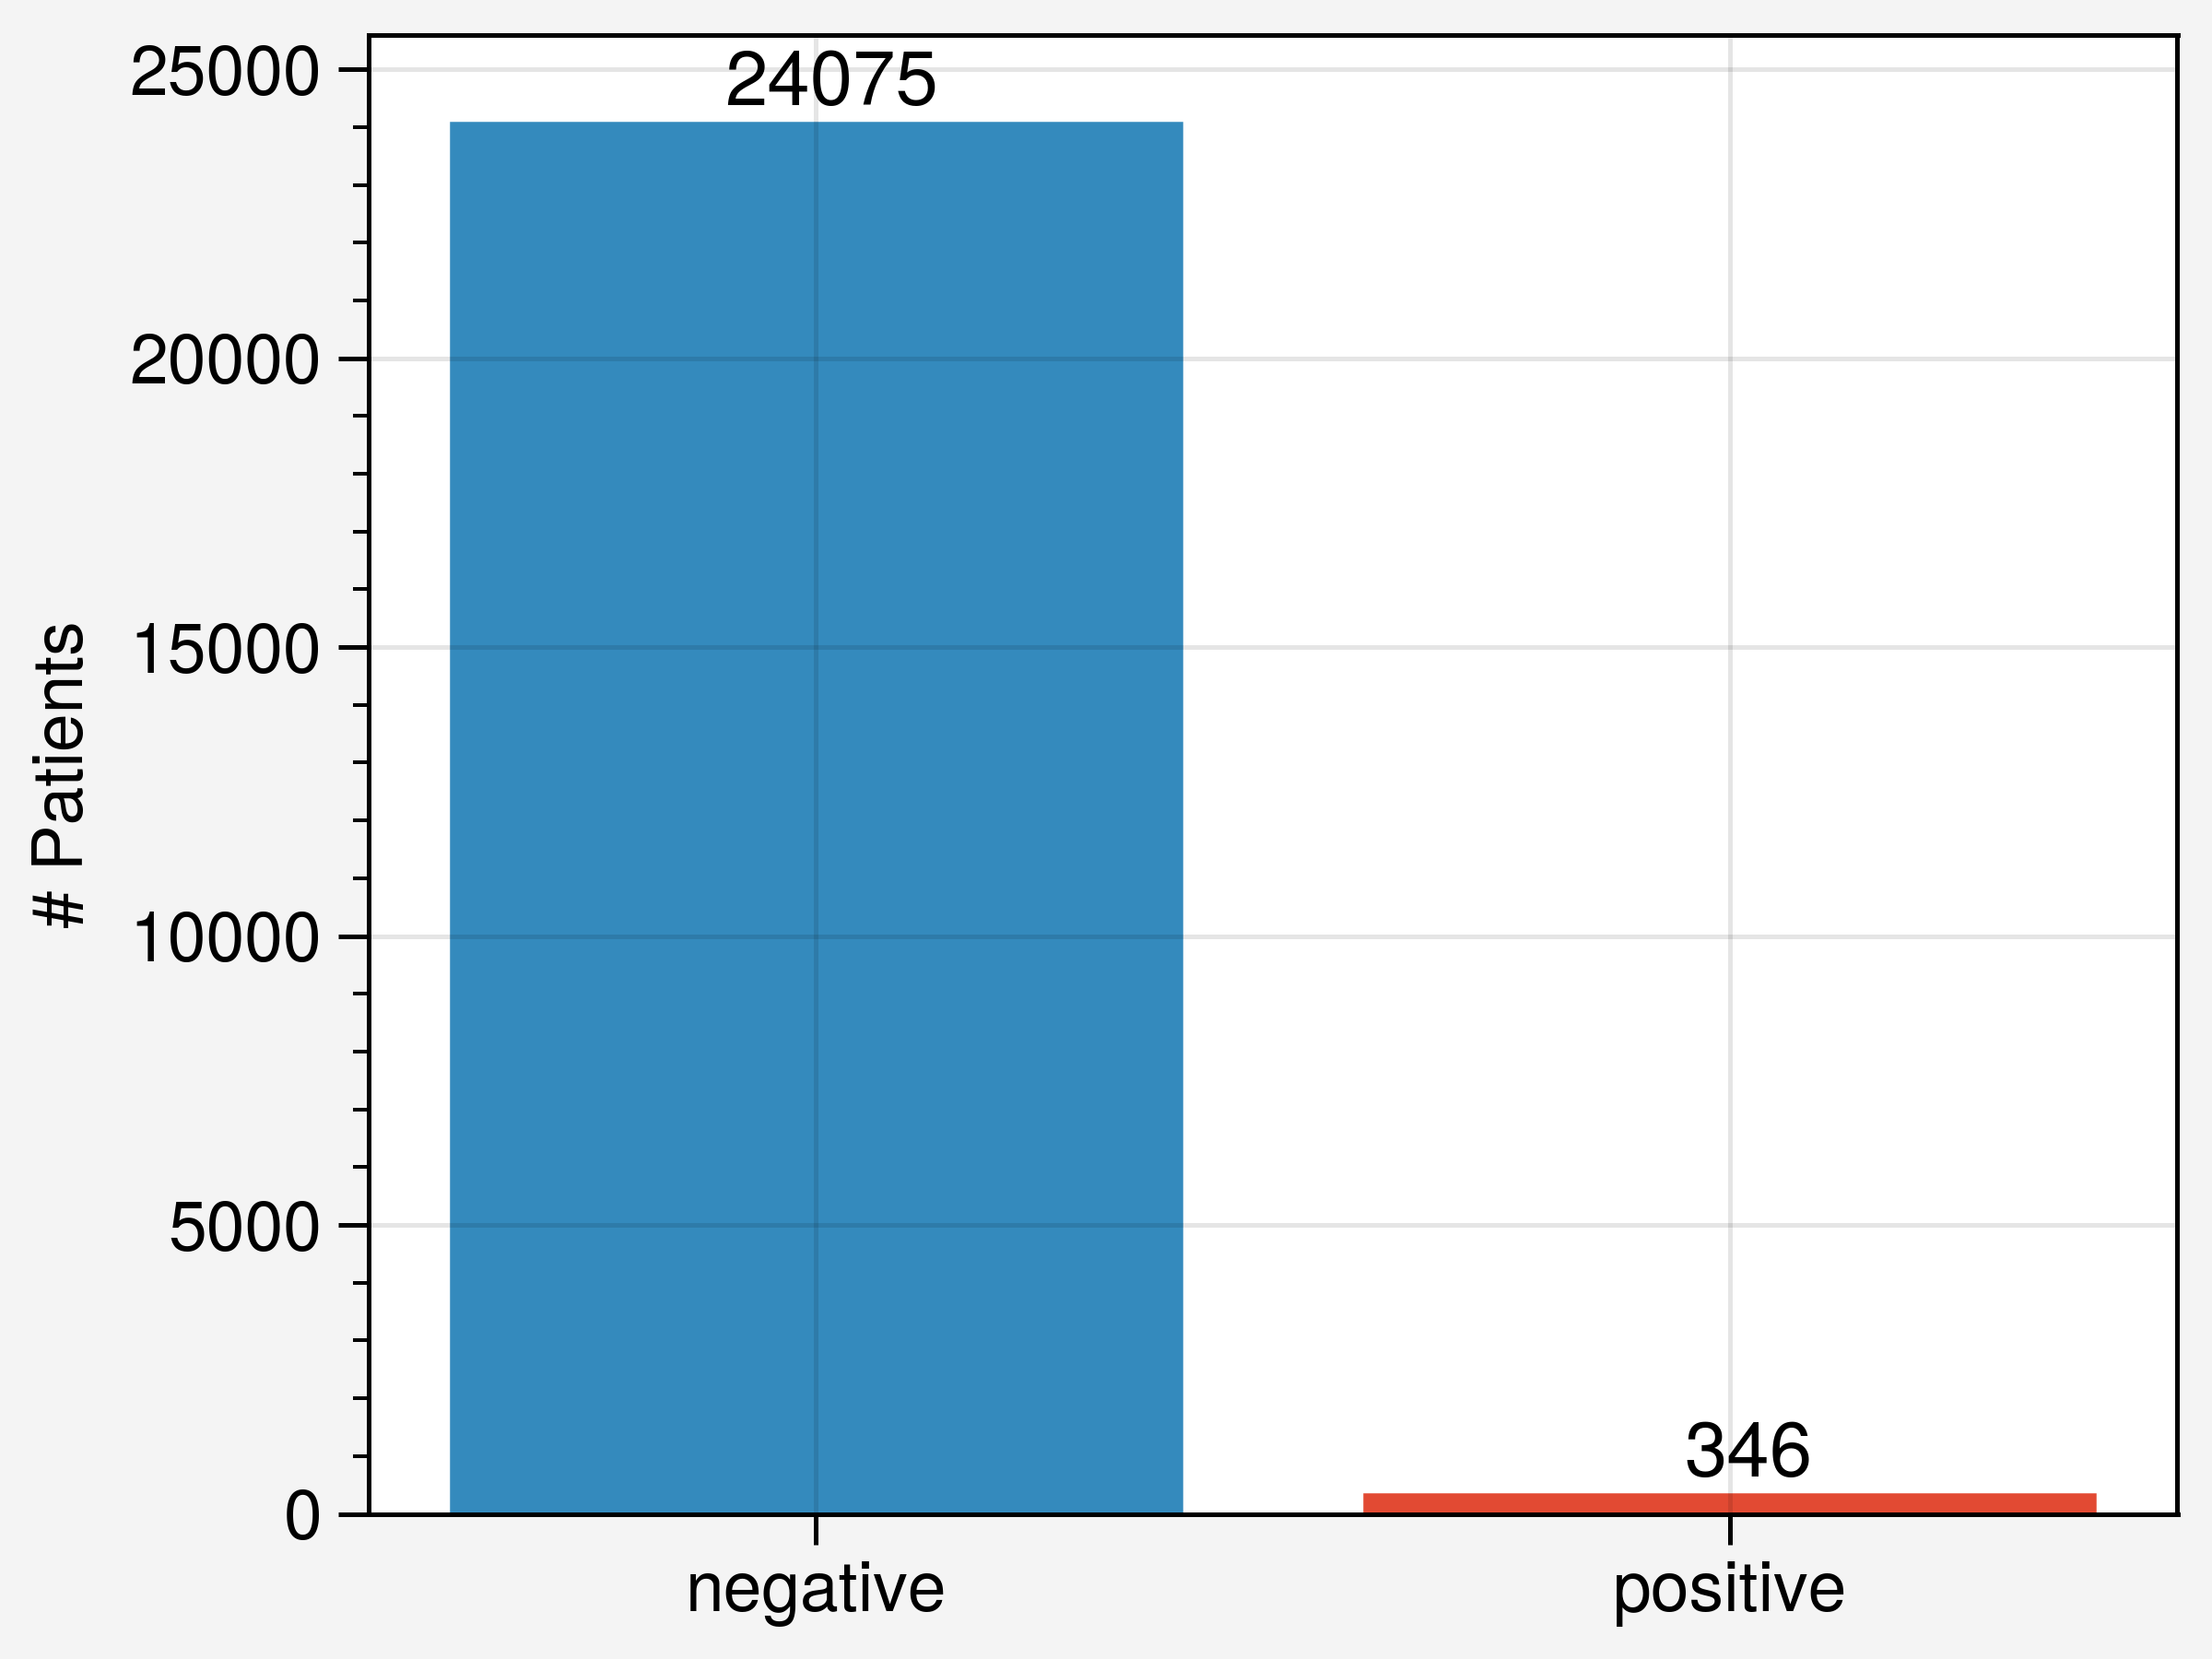

In [40]:
labels = ['negative', 'positive']
#mpl.rcParams['figure.dpi'] = 60
pos_mask = dfc.positive==1
pos_pat_count = dfc['PatientID'][pos_mask].nunique()
neg_pat_count = dfc['PatientID'][~pos_mask].nunique()
counts = np.array([neg_pat_count, pos_pat_count])
kwargs={'xlabel':'', 'show':False, 'yrange':(0,26000),
        'ylabel':'Patient Count', 'title':'Number of Patients with MRI scans'}
fig = pplt.figure(figsize=(4,3))
ax = fig.subplot(xlabel='', ylabel='# Patients')
barlist = ax.bar(labels, counts, kwargs=kwargs, color=colors[3])
barlist[0].set_color(colors[1])
barlist[1].set_color(colors[0])
ax.text(1-.05, pos_pat_count+300, pos_pat_count, fontsize=10)
ax.text(0-.1, neg_pat_count+300, neg_pat_count, fontsize=10)
ax.set_ylim(0,25600)
#ax.axes.formatter.use_mathtext(False)
# fig.savefig(join(fig_dir, 'basic_stats', 'positive_vs_neg_num_patients.png'), dpi=1000, 
#     bbox_to_inches='tight')

# Acquisition date

## For each volume

In [41]:
dft = dfcc[dfcc.InstanceCreationDate!=dt(2018,1,1)]
dftp = dft[dft.positive==1]
dftn = dft[dft.positive==0]
dftp['InstanceCreationDate'] = dftp['InstanceCreationDate'].apply(
    lambda x: dt(int(x.year), int(x.month), 1))
dftn['InstanceCreationDate'] = dftn['InstanceCreationDate'].apply(
    lambda x: dt(int(x.year), int(x.month), 1))

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [42]:
dftp = pd.DataFrame(dftp.groupby(['InstanceCreationDate']).SeriesInstanceUID.size())
dftn = pd.DataFrame(dftn.groupby(['InstanceCreationDate']).SeriesInstanceUID.size())
dftp.head()

,SeriesInstanceUID
InstanceCreationDate,
2020-03-01,100
2020-04-01,258
2020-05-01,410
2020-06-01,534
2020-07-01,178


In [43]:
dftp = dftp[(dftp.index>=dt(2018,11,1))&\
     (dftp.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')
dftn = dftn[(dftn.index>=dt(2018,11,1))&\
     (dftn.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')

In [44]:
dftp2 = dftp[(dftp.index>=dt(2020,1,1))&\
     (dftp.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')
dftn2 = dftn[(dftn.index>=dt(2020,1,1))&\
     (dftn.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later


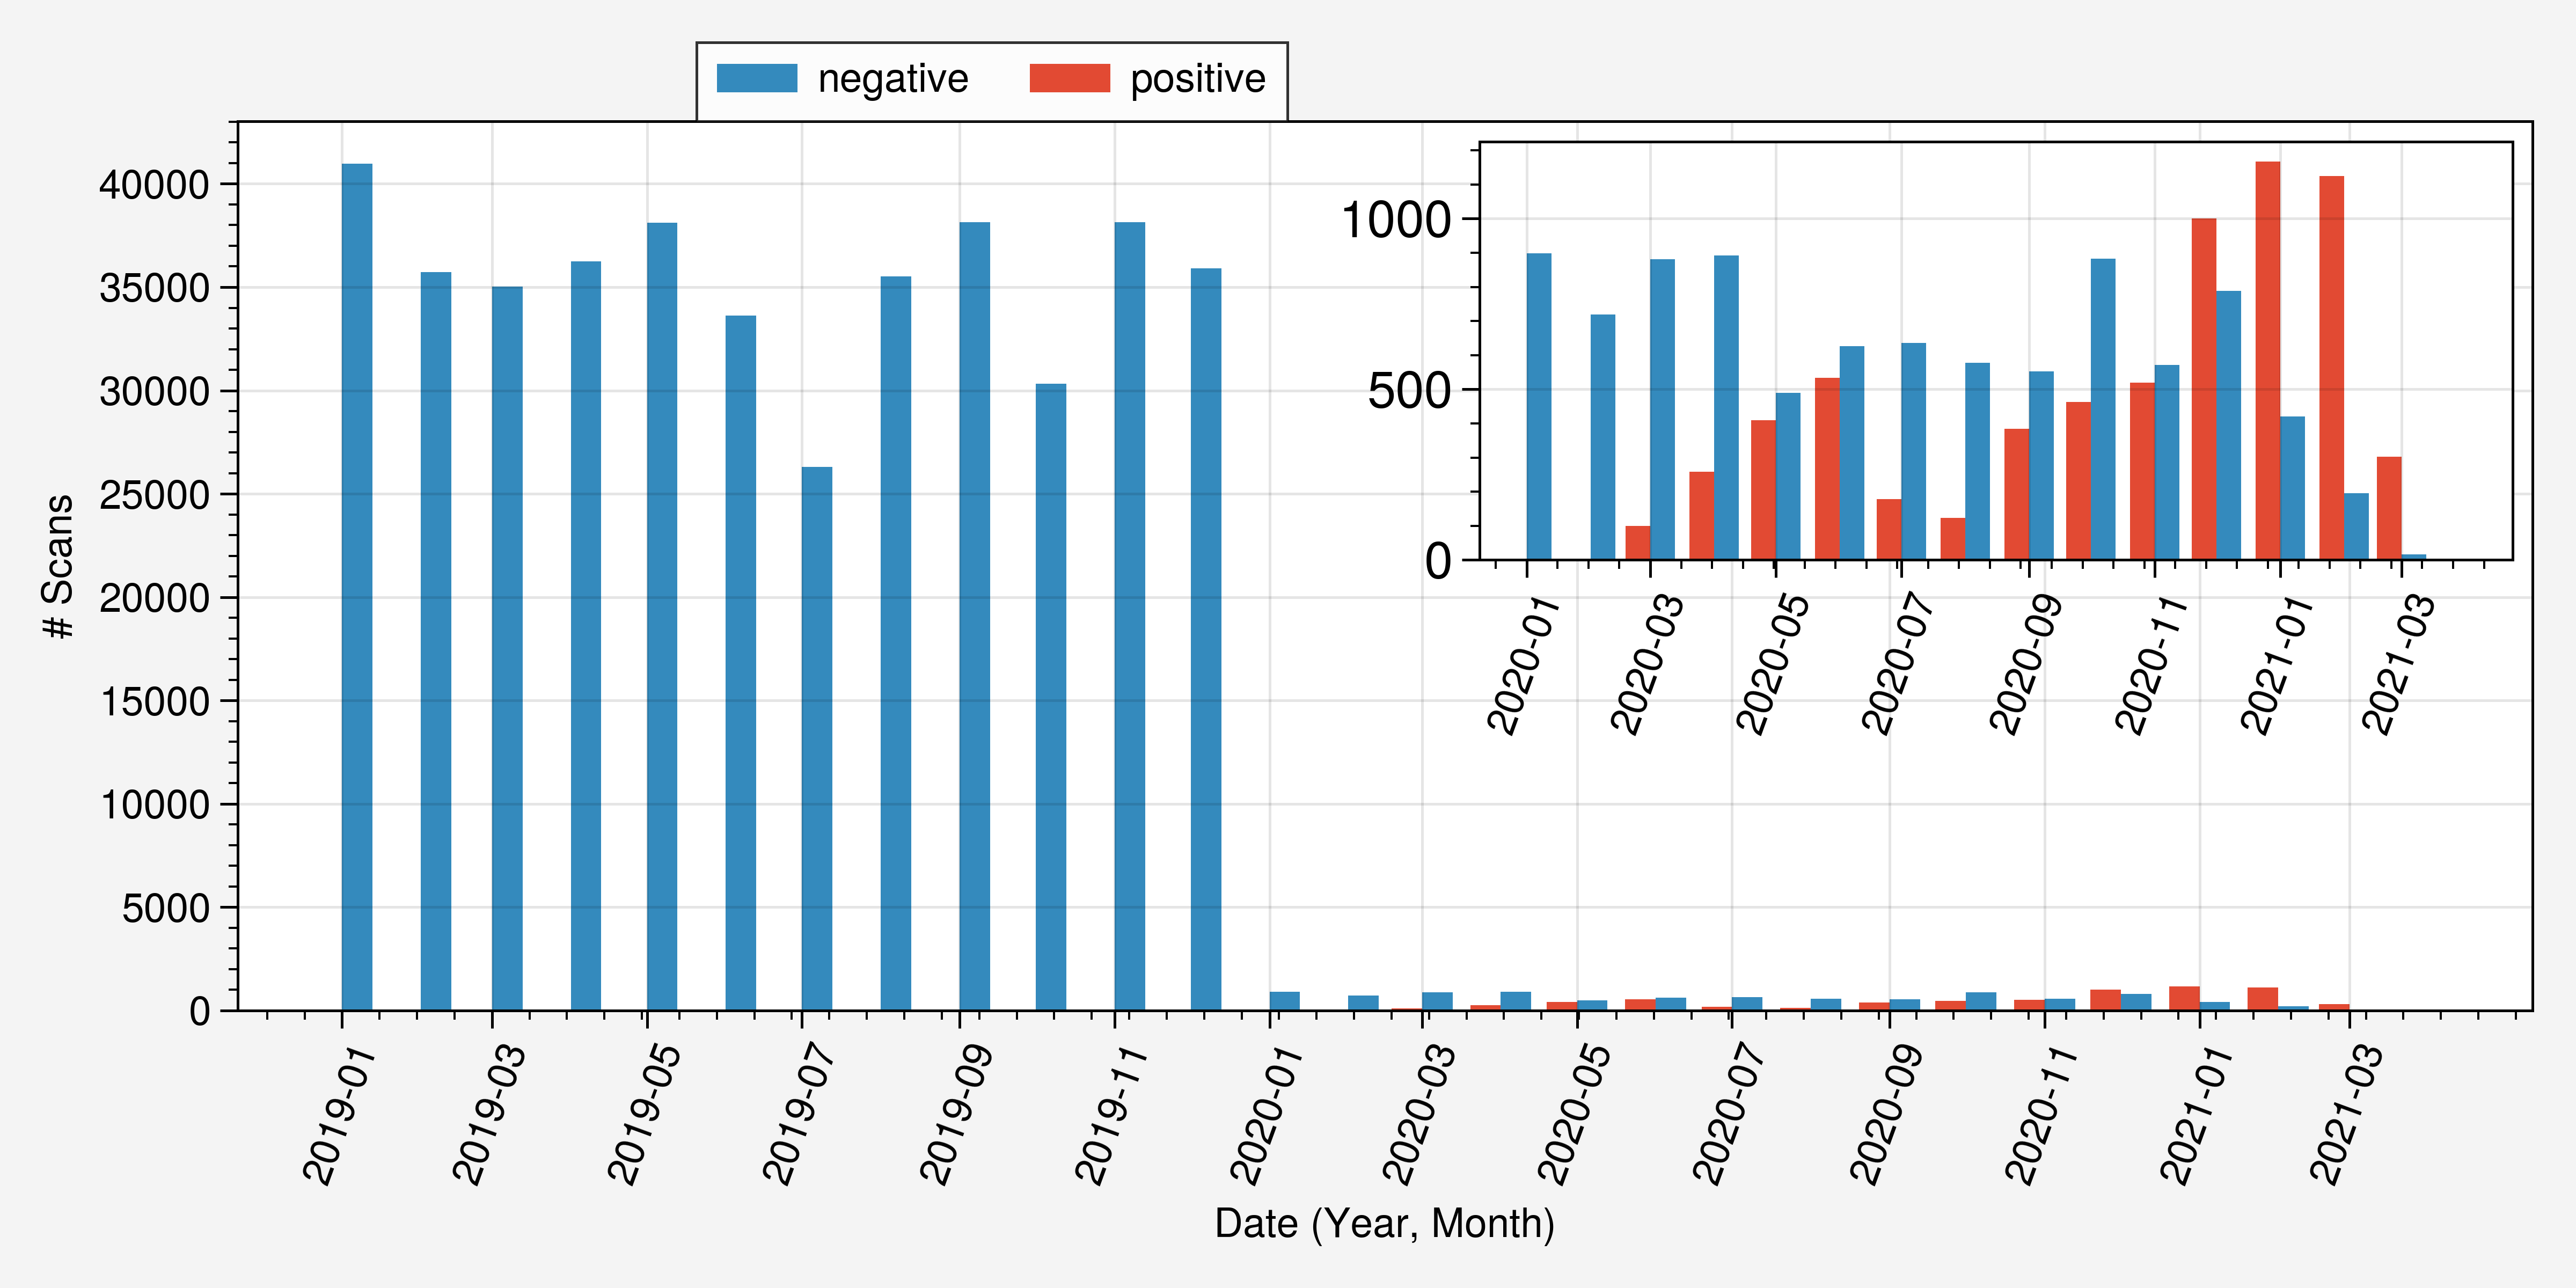

In [46]:
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(dftn.index+datetime.timedelta(6), dftn.SeriesInstanceUID, 
    width=12, color=colors[1],label='negative')
ax.bar(dftp.index-datetime.timedelta(6), dftp.SeriesInstanceUID, width=12, color=colors[0],
    label='positive')
axins = inset_axes(ax,
    width="45%", # width = 30% of parent_bbox
    height=1.3, # height : 1 inch
    loc=1)
                              
axins.bar(dftn2.index+datetime.timedelta(6), dftn2.SeriesInstanceUID, width=12, 
            color=colors[1], )
axins.bar(dftp2.index-datetime.timedelta(6), dftp2.SeriesInstanceUID, width=12, 
    color=colors[0],)

axins.xaxis.set_major_locator(mdates.MonthLocator())
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axins.tick_params(axis='x', which='major',  rotation=70,)
axins.tick_params(axis='y', which='major', labelsize=11.5,)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', which='major',  rotation=70)
ax.tick_params(axis='y', which='major', )
x_ticks = axins.get_xticks()
_ = axins.set_xticks(x_ticks[::2])

x_ticks = ax.get_xticks()
_ = ax.set_xticks(x_ticks[1:-2:2])
ax.set_ylabel('# Scans', )
ax.set_xlabel('Date (Year, Month)', )
ax.legend(ncol=2, loc=(.2,1), )
fig.tight_layout()
fig.savefig(join(fig_dir, 'basic_stats','ac_date_pos_neg.png'), bbox_to_inches='tight',
        dpi=1000)

# Studies

In [65]:
datetime.datetime(2020,2,28)

datetime.datetime(2020, 2, 28, 0, 0)

In [72]:
df_studies = pd.read_csv(f"{table_dir}/studies_clean.csv", 
    converters={'DateTimeStart':utils.date_time_converter})
dftps = df_studies[df_studies.Positive==1]
dftns = df_studies[(df_studies.Positive==0) | ((df_studies.Positive.isna()) & (df_studies.DateTimeStart<np. datetime64("2020-02-27 12:00:00")) )] 

### Number of scans per study

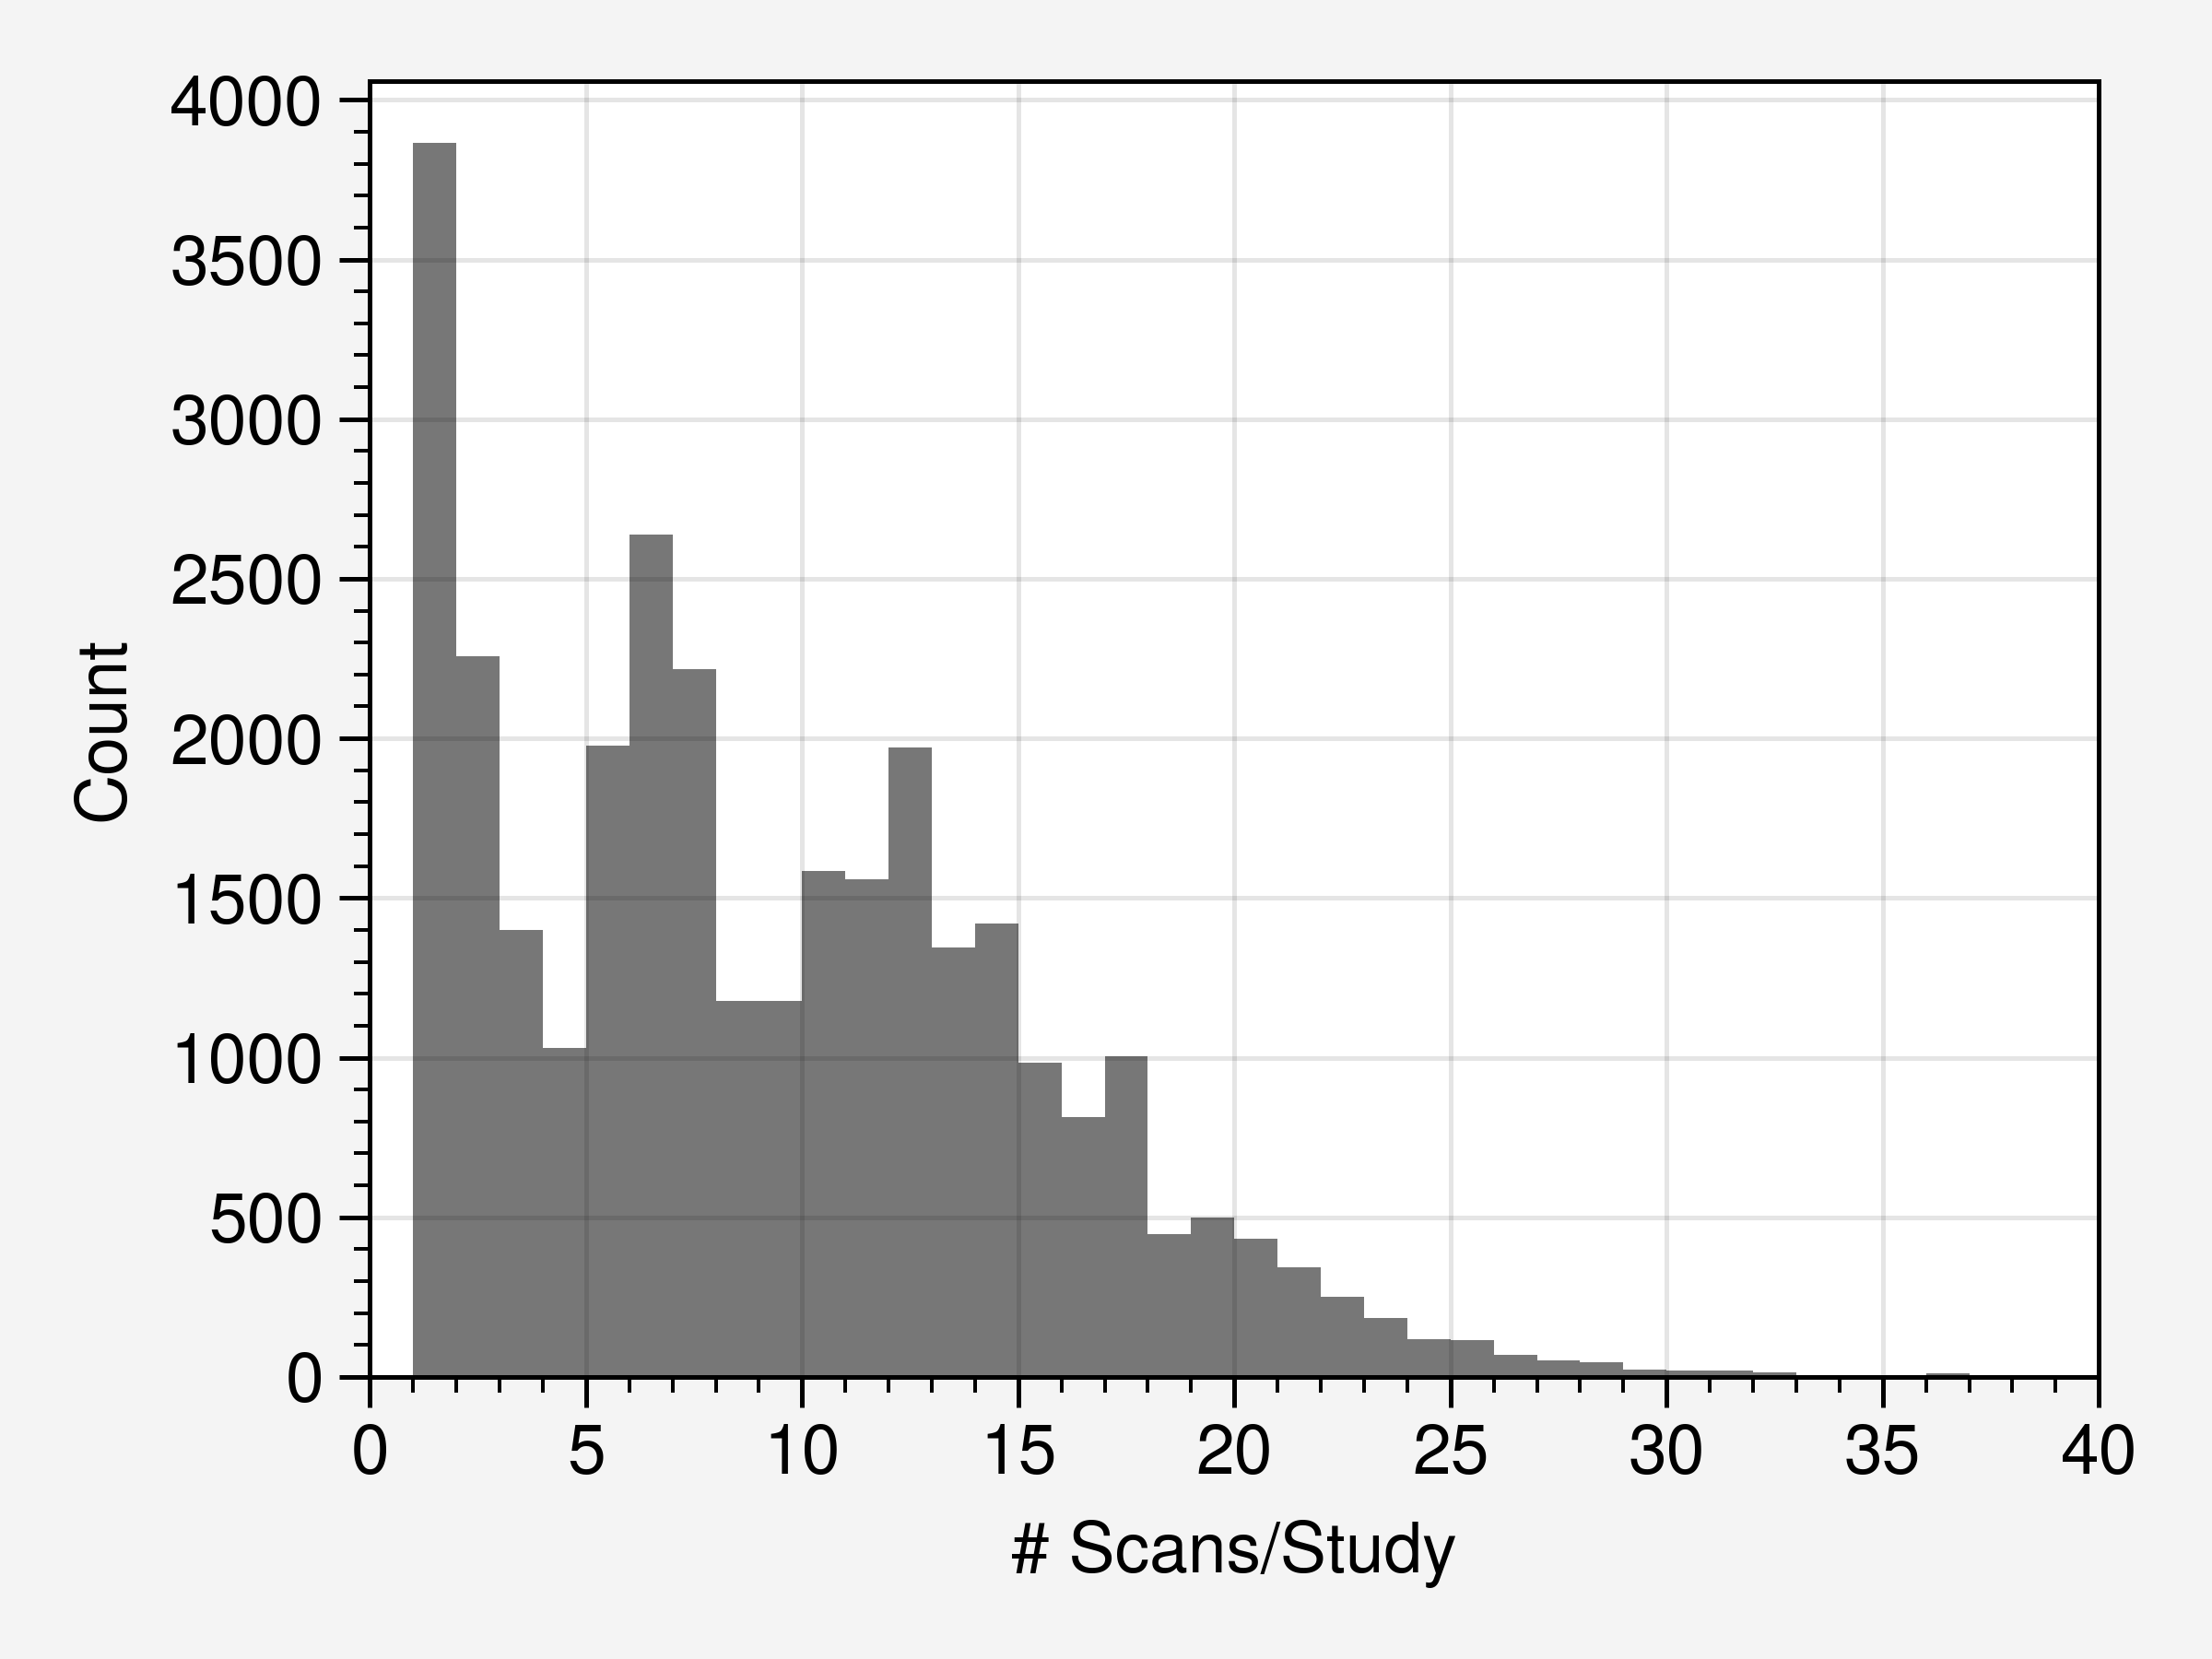

In [76]:
fig,ax = plt.subplots(figsize=(4,3))
# dftns.NumVolumes.hist(bins=np.arange(0,38), color=colors[1], ax=ax)
# dftps.NumVolumes.hist(bins=np.arange(0,38), color=colors[0], ax=ax)
df_studies.NumVolumes.hist(bins=np.arange(0,38), color=colors[3], ax=ax)
ax.set_xlim(0,40)       
ax.set_xlabel('# Scans/Study')
ax.set_ylabel('Count')
fig.tight_layout()
#fig.savefig(join(fig_dir, 'basic_stats','num_volumes_per_study.png'),dpi=1000)

In [77]:
dftps['DateTimeStart'] = dftps['DateTimeStart'].apply(
    lambda x: dt(int(x.year), int(x.month), 1))
dftns['DateTimeStart'] = dftns['DateTimeStart'].apply(
    lambda x: dt(int(x.year), int(x.month), 1))

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [78]:
dftns = dftns[dftns.DateTimeStart!=dt(2018,1,1)]

In [83]:
dftps1 = pd.DataFrame(dftps.groupby(['DateTimeStart']).count())
dftns1 = pd.DataFrame(dftns.groupby(['DateTimeStart']).count())

dftps2 = dftps1[(dftps1.index>=dt(2020,3,1))&\
     (dftps1.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')
dftns2 = dftns1[(dftns1.index>=dt(2020,1,1))&\
     (dftns1.index<=dt(2021,4,16))]#.set_index('InstanceCreationDate')

## Studies over time

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


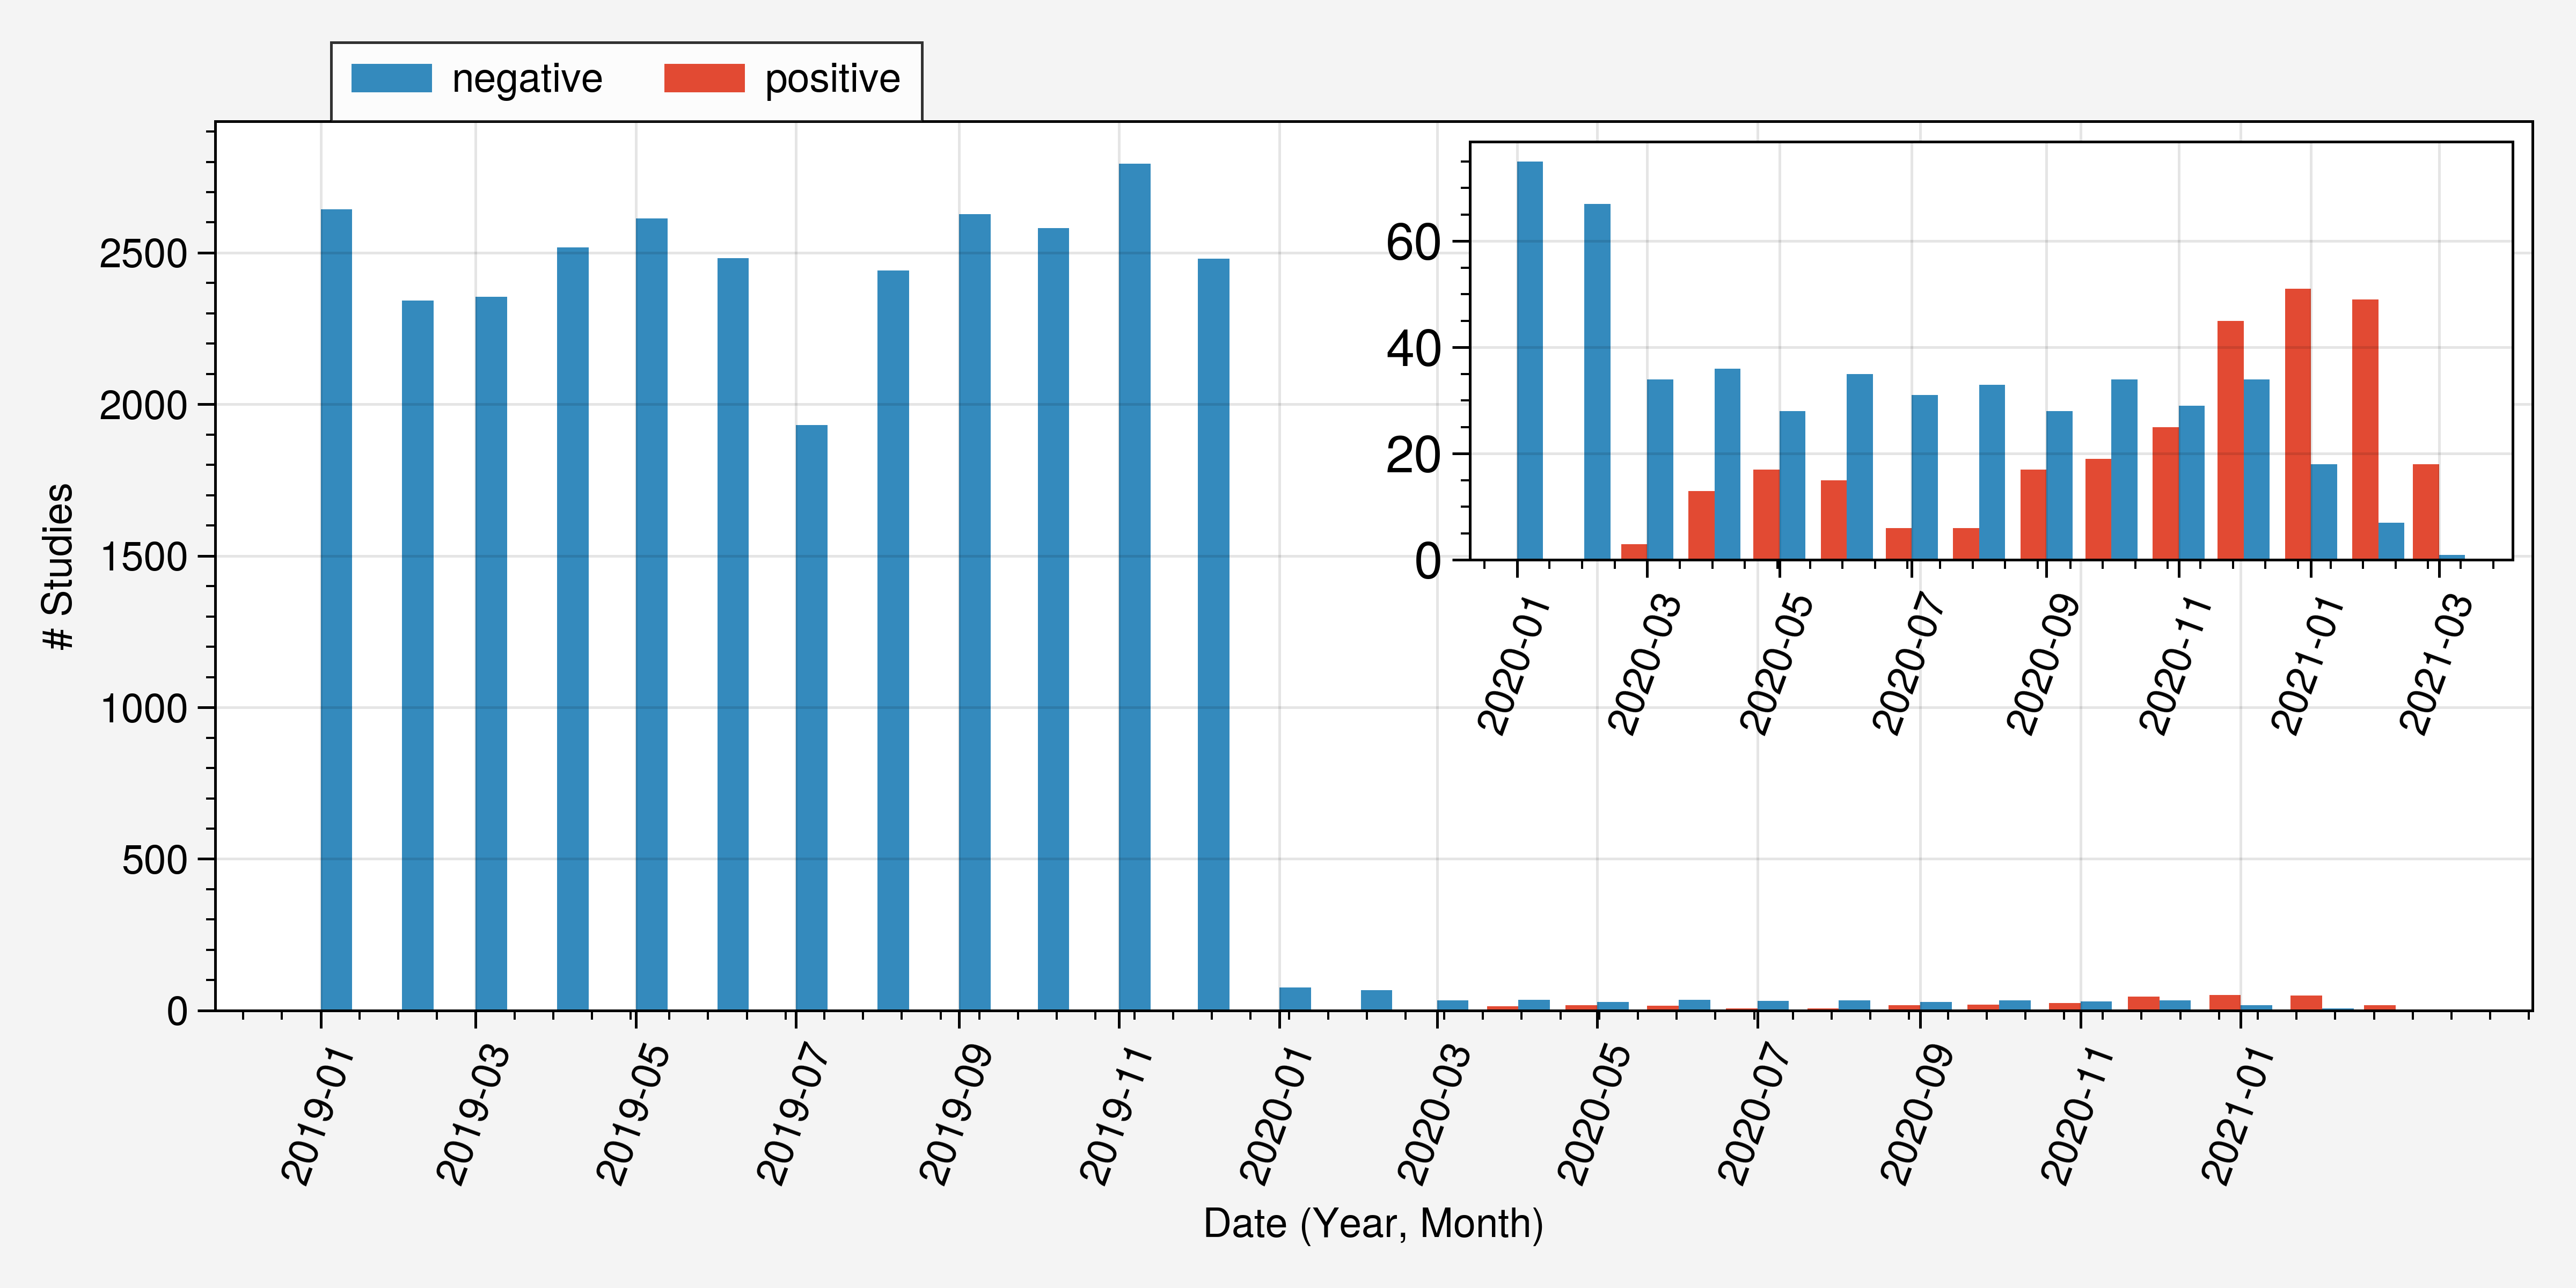

In [84]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.rcParams["figure.dpi"] = 300

#fig = pplt.figure(refwidth=1.8)
#ax = fig.subplots((1,2))
#print(ax)
ax.bar(dftns1.index+datetime.timedelta(6), dftns1.PatientID, 
    width=12, color=colors[1],label='negative')
ax.bar(dftps1.index-datetime.timedelta(6), dftps1.PatientID, width=12, color=colors[0],
    label='positive')
axins = inset_axes(ax,
                    width="45%", # width = 30% of parent_bbox
                    height=1.3, # height : 1 inch
                    loc=1)
                              
axins.bar(dftns2.index+datetime.timedelta(6), dftns2.PatientID, width=12, color=colors[1], )
axins.bar(dftps2.index-datetime.timedelta(6), dftps2.PatientID, width=12, color=colors[0],)

axins.xaxis.set_major_locator(mdates.MonthLocator())
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axins.tick_params(axis='x', which='major',  rotation=70, )
axins.tick_params(axis='y', which='major', labelsize=11.5)#,
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', which='major',  rotation=70)
ax.tick_params(axis='y', which='major', )
x_ticks = axins.get_xticks()
_ = axins.set_xticks(x_ticks[::2])

x_ticks = ax.get_xticks()
_ = ax.set_xticks(x_ticks[1:-2:2])
ax.set_ylabel('# Studies', )
ax.set_xlabel('Date (Year, Month)', )
ax.legend(ncol=2, loc=(.05,1),)
fig.tight_layout()
# fig.savefig(join(fig_dir, 'basic_stats','studies_date_pos_neg.png'),dpi=1000, bbox_to_inches='tight')

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


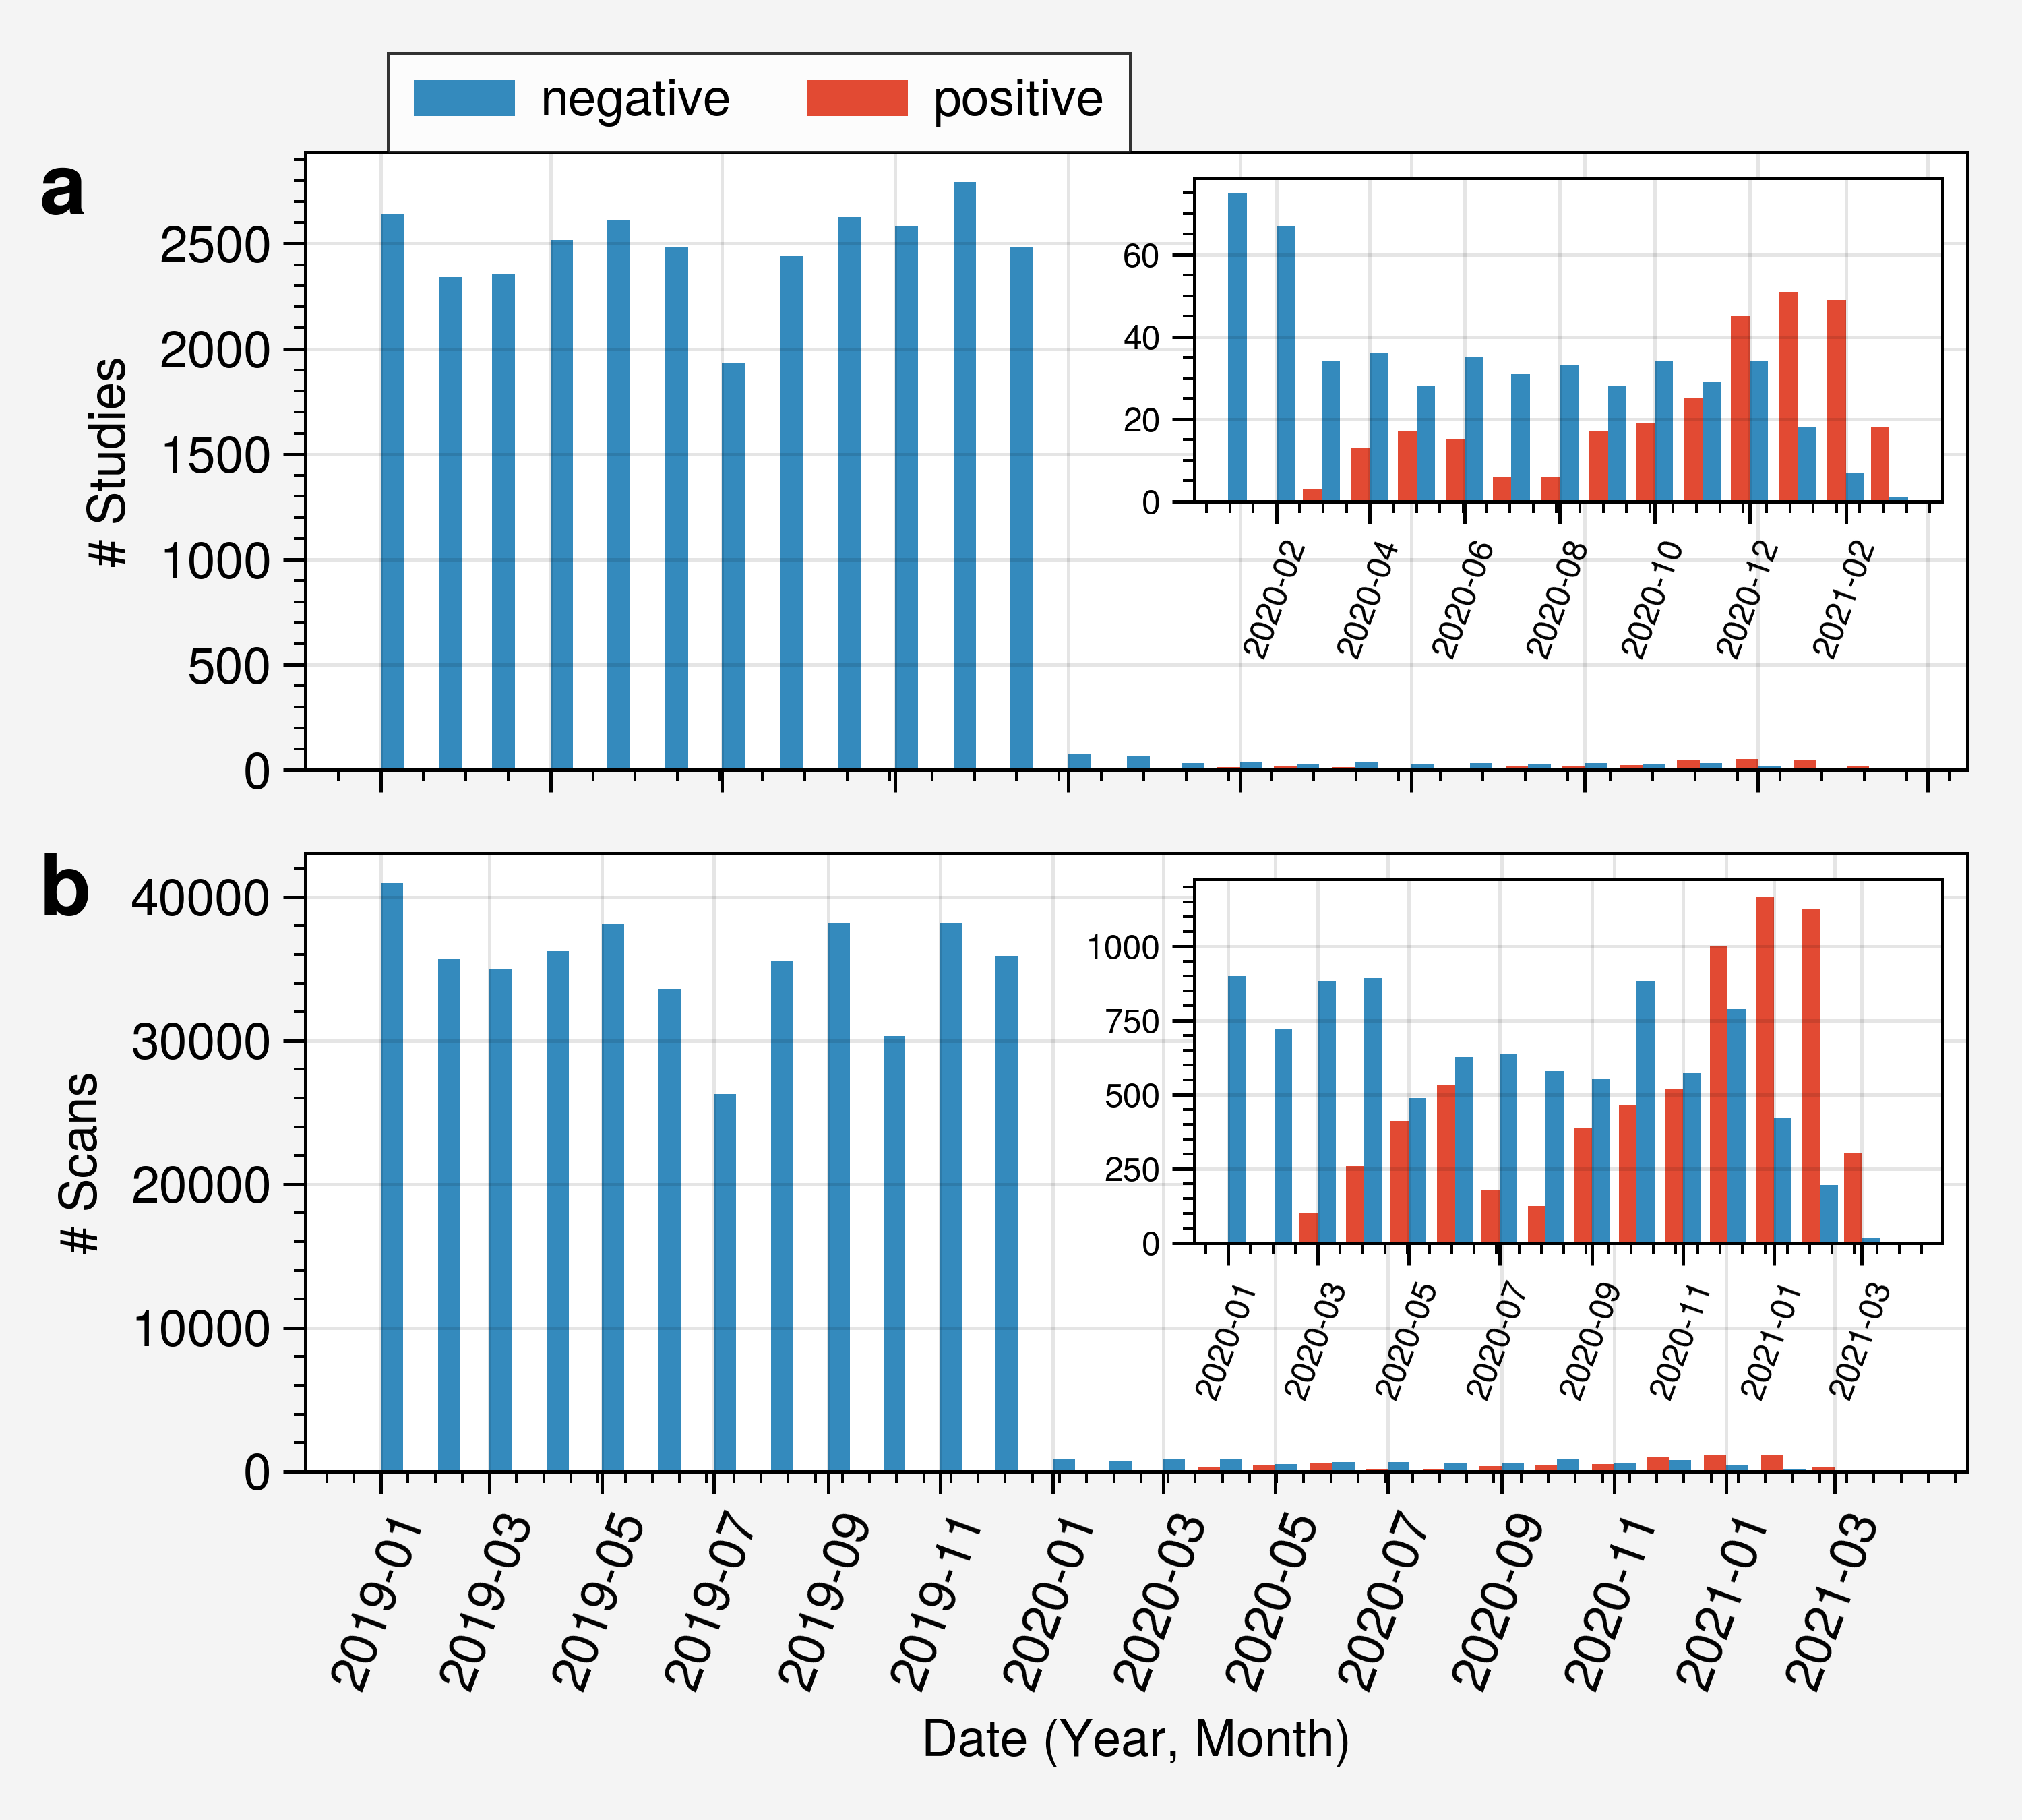

In [86]:
fig, ax = plt.subplots(2,1, figsize=(5,4.5))
#plt.rcParams["figure.dpi"] = 300
ax1 = ax[1]
ax = ax[0]
#fig = pplt.figure(refwidth=1.8)
#ax = fig.subplots((1,2))
#print(ax)
ax.bar(dftns1.index+datetime.timedelta(6), dftns1.PatientID, 
    width=12, color=colors[1],label='negative')
ax.bar(dftps1.index-datetime.timedelta(6), dftps1.PatientID, width=12, color=colors[0],
    label='positive')
axins = inset_axes(ax,
                    width="45%", # width = 30% of parent_bbox
                    height=.8, # height : 1 inch
                    loc=1)
                              
axins.bar(dftns2.index+datetime.timedelta(6), dftns2.PatientID, width=12, color=colors[1], )
axins.bar(dftps2.index-datetime.timedelta(6), dftps2.PatientID, width=12, color=colors[0],)

axins.xaxis.set_major_locator(mdates.MonthLocator())
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axins.tick_params(axis='x', which='major',  rotation=70, labelsize=6)
axins.tick_params(axis='y', which='major', labelsize=6)#,
#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xticklabels([])
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.tick_params(axis='x', which='major',  rotation=70)
ax.tick_params(axis='y', which='major', )
x_ticks = axins.get_xticks()
_ = axins.set_xticks(x_ticks[1:-1:2])

#x_ticks = ax.get_xticks()
#_ = ax.set_xticks(x_ticks[1:-2:2])
ax.set_ylabel('# Studies', )
#ax.set_xlabel('Date (Year, Month)', )
ax.legend(ncol=2, loc=(.05,1),)


##################################################
ax1.bar(dftn.index+datetime.timedelta(6), dftn.SeriesInstanceUID, 
    width=12, color=colors[1],label='negative')
ax1.bar(dftp.index-datetime.timedelta(6), dftp.SeriesInstanceUID, width=12, color=colors[0],
    label='positive')
axins = inset_axes(ax1,
    width="45%", # width = 30% of parent_bbox
    height=.9, # height : 1 inch
    loc=1)
                              
axins.bar(dftn2.index+datetime.timedelta(6), dftn2.SeriesInstanceUID, width=12, 
            color=colors[1], )
axins.bar(dftp2.index-datetime.timedelta(6), dftp2.SeriesInstanceUID, width=12, 
    color=colors[0],)

axins.xaxis.set_major_locator(mdates.MonthLocator())
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axins.tick_params(axis='x', which='major',  rotation=70,labelsize=6)
axins.tick_params(axis='y', which='major', labelsize=6,)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.tick_params(axis='x', which='major',  rotation=70)
ax1.tick_params(axis='y', which='major', )
x_ticks = axins.get_xticks()
_ = axins.set_xticks(x_ticks[::2])

x_ticks = ax1.get_xticks()
_ = ax1.set_xticks(x_ticks[1:-2:2])
ax1.set_ylabel('# Scans', )
ax1.set_xlabel('Date (Year, Month)', )
#ax.legend(ncol=2, loc=(.2,1), )
ax.text(-.16,.9,string.ascii_lowercase[0], transform=ax.transAxes,
    size=15, weight='bold')
ax1.text(-.16,.9,string.ascii_lowercase[1], transform=ax1.transAxes,
    size=15, weight='bold')
mpl.pyplot.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig(join(fig_dir, 'basic_stats','studies_and_scans.png'),dpi=1000, )

## Studies per patients

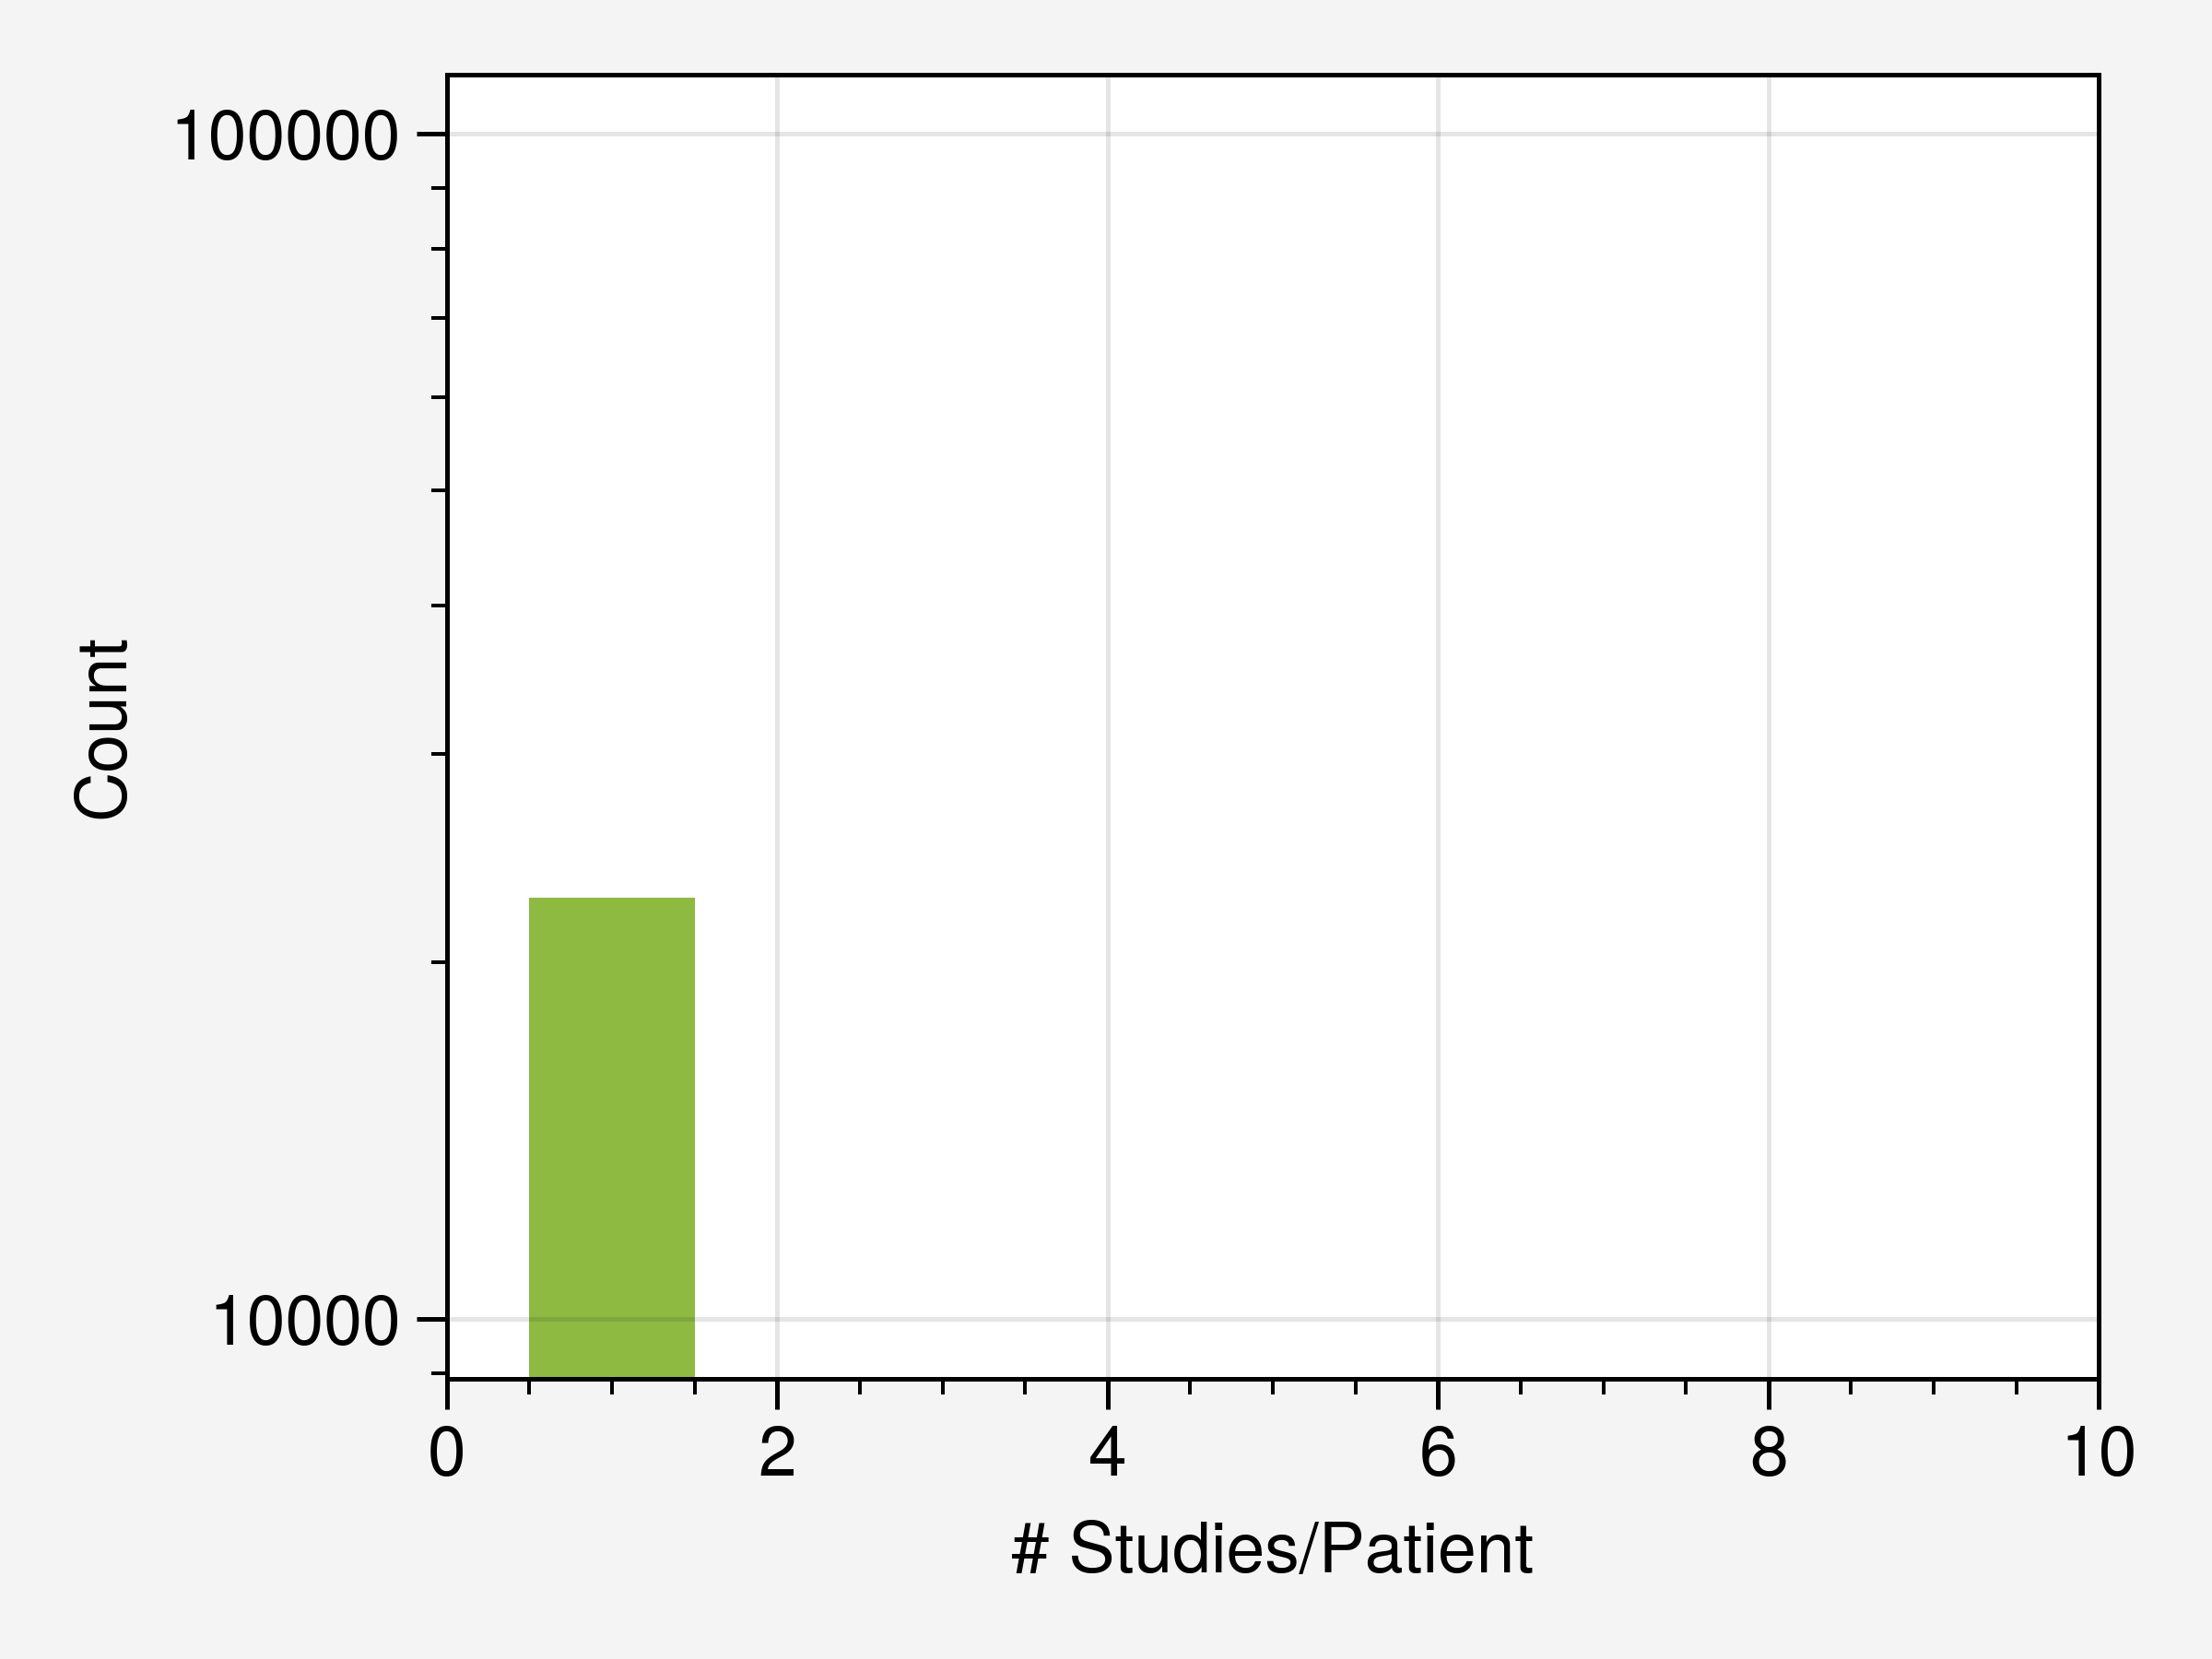

In [26]:
fig, ax = plt.subplots(figsize=(4,3))
dftns.PatientID.value_counts().hist(bins=np.arange(-.5,10.5,1), ax=ax, color=colors[5])
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel('# Studies/Patient')
ax.set_xlim(0,10)
fig.tight_layout()

(0.0, 10.0)

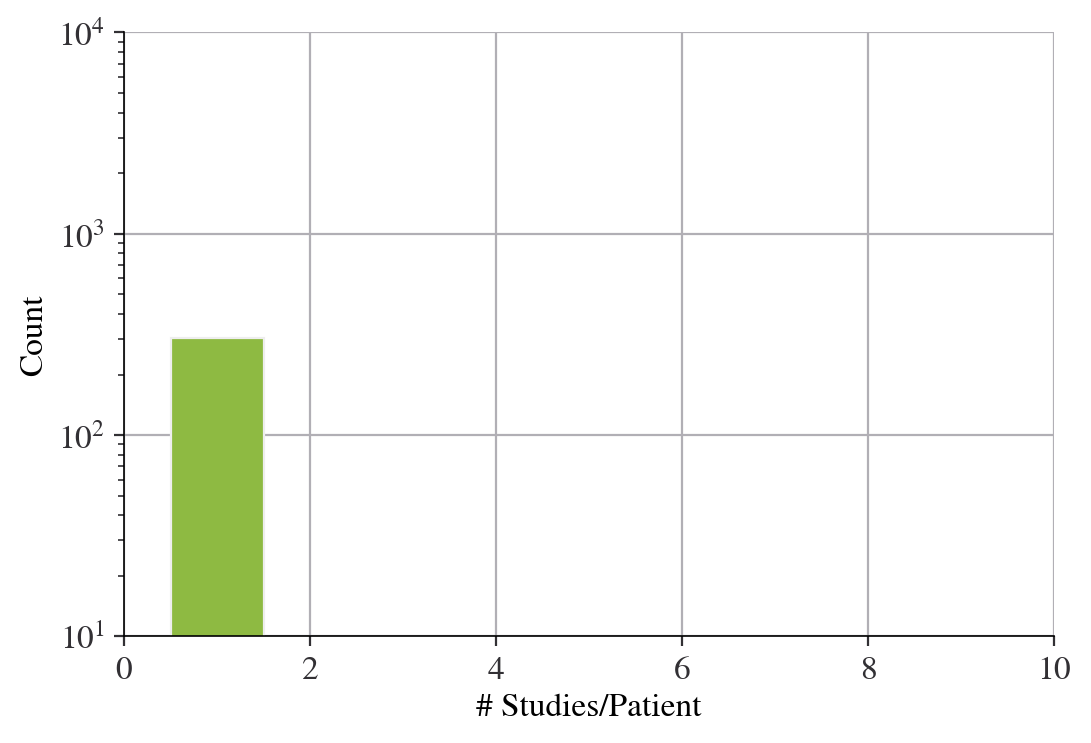

In [243]:
fig, ax = plt.subplots()
dftps.PatientID.value_counts().hist(bins=np.arange(-.5,10.5,1), ax=ax, color=colors[5])
ax.set_yscale('log')
ax.set_ylabel('Count')
ax.set_xlabel('# Studies/Patient')
ax.set_xlim(0,10)

## Scans per study